In [66]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import PIL
from functools import partial
import PIL.Image
from nimbus.common.parallel import parallelize

In [2]:
with open('coords_raw_text.txt') as f:
    end_points = np.array([tuple(map(lambda x: float(x), line.strip().removeprefix('\\psdots[dotstyle=*,linecolor=ududff](').removesuffix(')').split(',')))
              for line in f.readlines()])
    start_points = np.random.normal(loc=0, scale=0.5, size=end_points.shape)

In [ ]:
def optimal_transport(start_points, end_points, t):
    fig, ax = plt.subplots(1, subplot_kw=dict(aspect='equal'))
    ax.grid()
    mid_points = t * end_points + (1. - t) * start_points
    ax.scatter(start_points[:,0], start_points[:,1], s=3, color='red')
    ax.scatter(mid_points[:,0], mid_points[:,1], s=3, color='royalblue')
    ax.scatter(end_points[:,0], end_points[:,1], s=3, color='k')
    [ax.plot([s[0], e[0]], [s[1], e[1]], c='royalblue', linewidth=0.5, alpha=0.5, zorder=-1)[0]
        for s, e in zip(start_points, mid_points)]
    
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    image = data.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    return image
def helper_optimal_transport(args):
    return optimal_transport(start_points=args['start_points'], end_points=args['end_points'], t=args['t'])

In [ ]:
ret = parallelize(helper_optimal_transport, args=[dict(start_points=start_points, end_points=end_points, t=t) for t in np.linspace(0,1,100)])
pil_images = [Image.fromarray(r) for r in ret]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.52it/s]


In [ ]:
pil_images[0].save('no_snow.gif', save_all=True, append_images=pil_images[1:], duration=80, loop=True)

In [32]:
fig = ret[0]

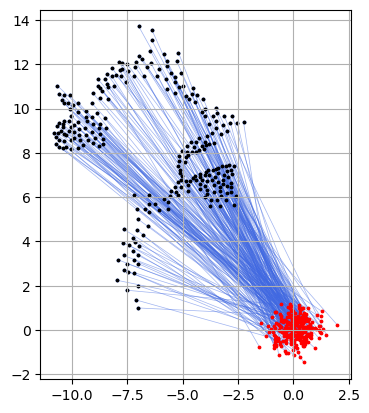

In [84]:
optimal_transport(start_points, end_points, t=1)

In [52]:
def update(frame_idx, n_frames, intermediate_points_artist, trace_artists: list):
    t = frame_idx / n_frames
    mid_points = t * end_points + (1. - t) * start_points
    intermediate_points_artist.set_offsets(mid_points)
    for i, artist in enumerate(trace_artists):
        artist.set_data([start_points[i][0], mid_points[i][0]], [start_points[i][1], mid_points[i][1]])

    return [intermediate_points_artist] + trace_artists

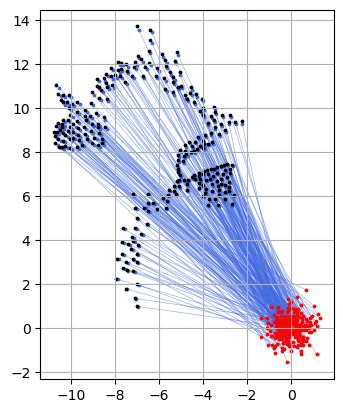

In [73]:
t = 0.5
mid_points = t * end_points + (1. - t) * start_points

fig, ax = plt.subplots(1, subplot_kw=dict(aspect='equal'))
ax.grid()
ax.scatter(start_points[:,0], start_points[:,1], s=3, color='red')
intermediate_points_artist = ax.scatter(mid_points[:,0], mid_points[:,1], s=3, color='royalblue')
ax.scatter(end_points[:,0], end_points[:,1], s=3, color='k')
trace_artists = [
    ax.plot([s[0], e[0]], [s[1], e[1]], c='royalblue', linewidth=0.5, alpha=0.5, zorder=-1)[0] for s, e in zip(start_points, mid_points)]

_update = partial(update, n_frames=100, intermediate_points_artist=intermediate_points_artist, trace_artists=trace_artists)
anim = animation.FuncAnimation(fig=fig, func=_update, frames=100, interval=0.1, repeat=False, blit=True)
anim.save(f'temp.gif', fps=10)

In [210]:
def diffeo(x, y, intensity=0.5):
    """
    Smooth 2D diffeomorphism with controllable intensity.
    intensity ~0.1 = slight warp, ~1.5 = stronger expansion.
    """
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    # Swirl effect (localized)
    swirl_strength = 0.3 * intensity
    theta_new = theta + swirl_strength * np.exp(-0.05 * r**2)

    # Expansion effect (monotone, no folding)
    expand_strength = 0.15 * intensity
    scale = 1 + expand_strength * (r**2 / (1 + r**2))  # smooth growth, saturates for large r

    # Map back to Cartesian
    x_new = r * np.cos(theta_new) * scale
    y_new = r * np.sin(theta_new) * scale
    # return x_new, y_new
    return x_new - 3, y_new + 2


def plot_mesh(ax, x, y):
    PLOT_LW = 1
    N = x.shape[0]
    for i in range(N):
        ax.plot(x[i,:], y[i,:], color='blue', lw=PLOT_LW, alpha=0.2)
        ax.plot(x[:,i], y[:,i], color='blue', lw=PLOT_LW, alpha=0.2)

    ax.axvline(0, zorder=-10, alpha=0.5, c='gray', lw=PLOT_LW)
    ax.axhline(0, zorder=-10, alpha=0.5, c='gray', lw=PLOT_LW)

def labeled_scatter(ax, x, y, label):
    ax.scatter(x, y, color='royalblue', zorder=5, s=1)
    ax.text(x+0.2, y, label, color='k', fontsize=12)

In [178]:
# Make a grid
n = 200
x = np.linspace(-20, 20, n)
y = np.linspace(-20, 20, n)
X, Y = np.meshgrid(x, y)

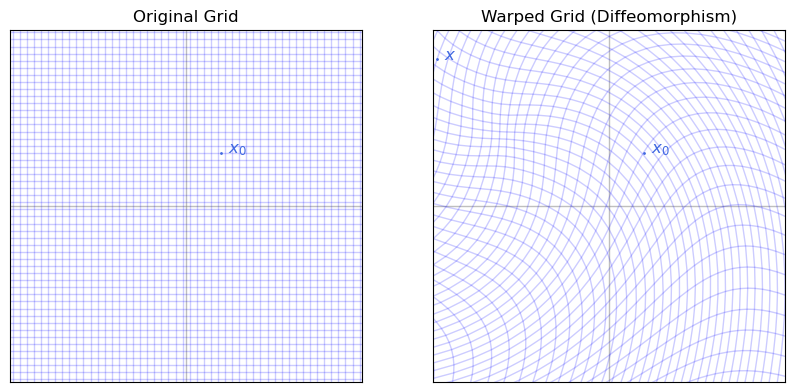

In [179]:

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=dict(xticks=[], yticks=[], xlim=(-5,5), ylim=(-5,5), aspect='equal'))


intensity = 5.1
# Apply diffeomorphism
X_new, Y_new = diffeo(X, Y, intensity=intensity)
# Point of interest
x0, y0 = 1, 1.5
x_map, y_map = diffeo(x0, y0, intensity=intensity)

plot_mesh(axs[0], X, Y)
plot_mesh(axs[1], X_new, Y_new)


axs[0].set_title("Original Grid")
axs[1].set_title("Warped Grid (Diffeomorphism)")

labeled_scatter(axs[0], x0, y0, label=r'$x_0$')
labeled_scatter(axs[1], x0, y0, label=r'$x_0$')
labeled_scatter(axs[1], x_map, y_map, label=r'$x$')

plt.show()


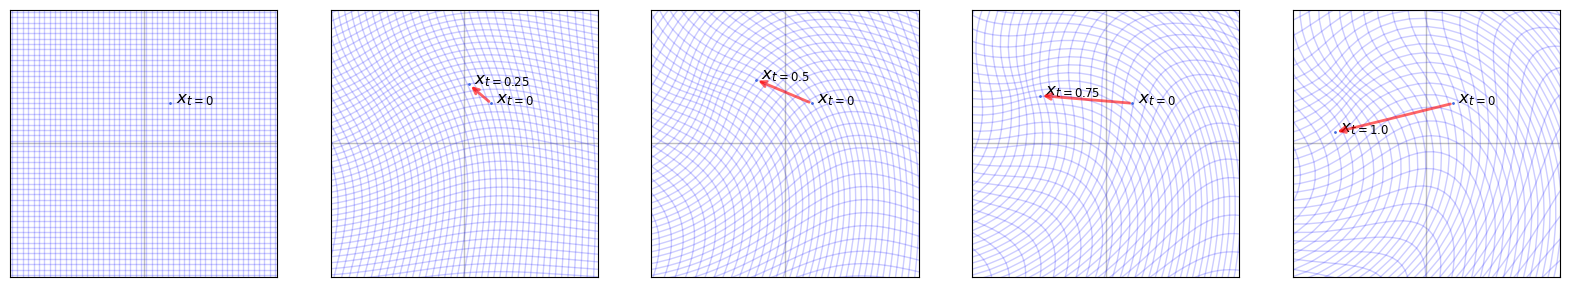

In [239]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4), subplot_kw=dict(xticks=[], yticks=[], xlim=(-5,5), ylim=(-5,5), aspect='equal'))
plot_mesh(axs[0], X, Y)

# Point of interest
x0, y0 = 1, 1.5
# intensity_values = [0, 1, 0, 1.3, 5.7]
intensity_values = [0, 2, 4, 6, 8]
max_intensity = max(intensity_values)
labeled_scatter(axs[0], x0, y0, label=rf"$x_{{t=0}}$")
for i, ax in enumerate(axs[1:].flatten()):
    intensity = intensity_values[1:][i]
    # print(intensity)
    x_map, y_map = diffeo(x0, y0, intensity=intensity)
    X_new, Y_new = diffeo(X, Y, intensity=intensity)
    plot_mesh(ax, X_new, Y_new)
    t = intensity / max_intensity
    labeled_scatter(ax, x0, y0, label=rf"$x_{{t=0}}$")
    labeled_scatter(ax, x_map + 3, y_map - 2, label=rf"$x_{{t={t}}}$")

    ax.annotate(
        '',                # No text
        xy=(x_map + 3, y_map - 2),       # Arrow tip
        xytext=(x0, y0),   # Arrow start
        arrowprops=dict(
            arrowstyle='->',  # Simple arrow
            color='r',
            linewidth=2, alpha=0.6
        )
    )

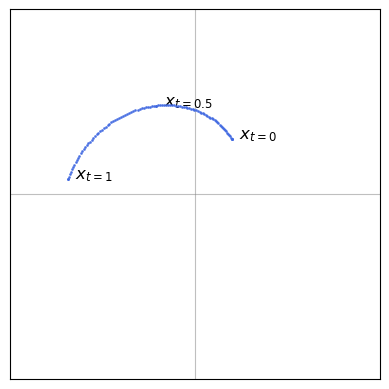

In [238]:
fig, ax = plt.subplots(1, subplot_kw=dict(xticks=[], yticks=[], xlim=(-5,5), ylim=(-5,5), aspect='equal'))
ax.scatter(x0, y0, color='royalblue', s=1)
ax.axvline(0, zorder=-10, alpha=0.5, c='gray', lw=0.8)
ax.axhline(0, zorder=-10, alpha=0.5, c='gray', lw=0.8)
labeled_scatter(ax, x0, y0, label=rf"$x_{{t=0}}$")
for intensity in np.linspace(0,8,101):
    if intensity == 4:
        labeled_scatter(ax,x_map + 3, y_map - 2, label=r"$x_{t=0.5}$")
    x_map, y_map = diffeo(x0, y0, intensity=intensity)
    ax.scatter(x_map + 3, y_map - 2, color='royalblue', zorder=5, s=1, alpha=0.8)

labeled_scatter(ax,x_map + 3, y_map - 2, label=r"$x_{t=1}$")